## Experiements with tensorflow
### Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
from math import pi

import matplotlib.pyplot as plt

### Test the functions that I am using
Tests:
- tf.math.sin &#9745;
- tf.signal.fft &#9745;
- tf.signal.fftshift &#9745;

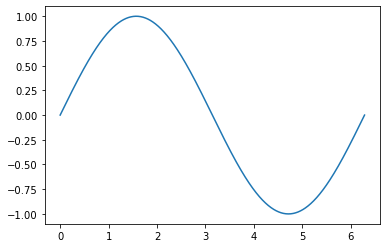

In [11]:
x = tf.cast(tf.linspace(0., 2*pi, 1000), dtype=tf.complex64)
y = tf.math.sin(x)

plt.plot(tf.math.real(x), tf.math.real(y))
plt.show()

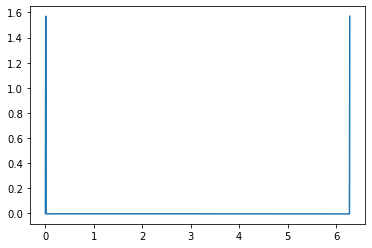

In [12]:
ft = tf.signal.fft(y)

plt.plot(tf.math.real(x), tf.math.real(ft))
plt.show()

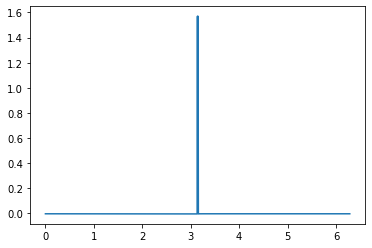

In [13]:
shifted = tf.signal.fftshift(ft)

plt.plot(tf.math.real(x), tf.math.real(shifted))
plt.show()

### Test layers
Tests:
- ConvDipole &#9745;
- WeightedSubtract &#9745;

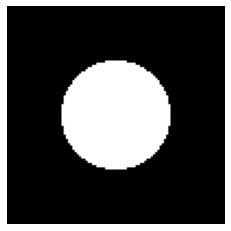

In [6]:
def sphere(shape, centre, radius: float, weight: float = 1.):
    x = tf.range(shape[0], dtype=tf.float32)
    y = tf.range(shape[1], dtype=tf.float32)
    z = tf.range(shape[2], dtype=tf.float32)

    X, Y, Z = tf.meshgrid(x, y, z, indexing='ij')

    in_sphere = (X - centre[0])**2 + (Y - centre[1])**2 + (Z - centre[2])**2 < radius**2

    tensor = tf.where(in_sphere, tf.ones(shape), tf.zeros(shape)) * weight

    return tensor

ball = sphere((100, 100, 100), (49.5, 49.5, 49.5), 25)

plt.imshow(ball[50, :, :], cmap = 'gray')
plt.axis('off')
plt.show()

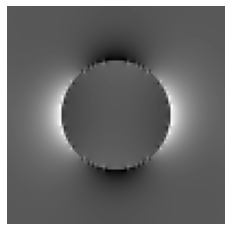

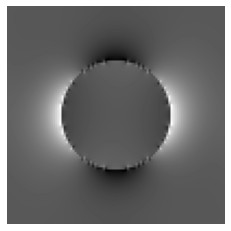

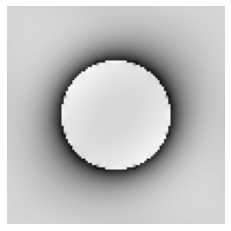

In [7]:
class ConvDipole(layers.Layer):
    def __init__(self, name: str = None) -> None:
        super().__init__(name=name)
        self.is_built = False
    
    @tf.function
    def call(self, img: tf.Tensor) -> tf.Tensor:
        if not self.is_built:
            self.kernel = self.generate_dipole(tf.shape(img))
            self.is_built = True

        kimg = tf.signal.fft3d(img)
        conv = tf.signal.ifft3d(kimg * self.kernel)
        return conv

    @staticmethod
    def generate_dipole(shape):
        ONE_THIRD = 1/3

        x = tf.linspace(-1, 1, shape[0])
        y = tf.linspace(-1, 1, shape[1])
        z = tf.linspace(-1, 1, shape[2])

        vx, vy, vz = tf.meshgrid(x, y, z, indexing='ij')

        denom = vx**2 + vy**2 + vz**2
        z_squared = vz**2

        kernel = tf.where(denom!=0, ONE_THIRD-(z_squared/denom), tf.zeros(shape, dtype = tf.float64))
        kernel = tf.signal.fftshift(kernel)
        kernel = tf.cast(kernel, tf.complex64) # Required for complatibility with fourier transformation

        return kernel

D = ConvDipole()

sus = tf.math.real(D(tf.cast(ball, tf.complex64)))

plt.imshow(sus[50, :, :], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(sus[:, 50, :], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(sus[:, :, 50], cmap='gray')
plt.axis('off')
plt.show()

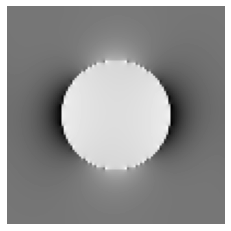

In [25]:
class WeightedSubtract(layers.Layer):
    def __init__(self, tau: float = 2, name: str = None) -> None:
        super().__init__(name=name)
        self.tau = tf.Variable(
            initial_value=tau,
            dtype=tf.float32,
            trainable=True
        )
    
    @tf.function
    def call(self, img, diff):
        return img - (self.tau * diff)

sub = WeightedSubtract()

diff = sub(ball, sus)

plt.imshow(diff[50, :, :], cmap='gray')
plt.axis('off')
plt.show()

### Test models
Tests:
- models &#9745;
- functions outside models &#9745;
- FixedStepNDI
    - 1 layer &#9745;
    - 2 layers &#9745;
    - 10 layers &#9744;

In [26]:
class Model(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1 = lambda a : a + 3
        self.layer2 = lambda a : a * 2

    def call(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

m = Model()

for n in range(10):
    print(m(n))

tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(20, shape=(), dtype=int32)
tf.Tensor(22, shape=(), dtype=int32)
tf.Tensor(24, shape=(), dtype=int32)


In [27]:
def add3(n):
    return n + 3

def mul2(n):
    return n * 2

class Model2(keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1 = add3
        self.layer2 = mul2

    def call(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

m = Model()

for n in range(10):
    print(m(n))

tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(20, shape=(), dtype=int32)
tf.Tensor(22, shape=(), dtype=int32)
tf.Tensor(24, shape=(), dtype=int32)


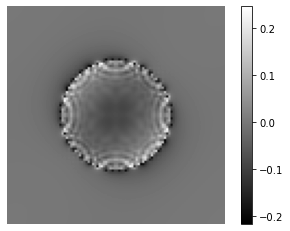

In [8]:
from models import FixedStepNDI

NDI = FixedStepNDI(100)

test = tf.math.real(NDI(sus, ball))

plt.imshow(test[:, :, 50], cmap = 'gray')
plt.axis('off')
plt.colorbar()
plt.show()